# MBSAS Clustering Analysis
In this notebook we explore the usage of the **MBSAS clustering** applied on the Customers' dataset we extracted in the previous step. 


We analyze **3 kind** of different approaches:
1. on the full dataset, picking the best hyperparameters according to the silhouette
2. on a manually selected subset of the dataset, picking the best hyperparameters according to the silhouette
3. on a reduced dataset (PCA=2), picking the best hyperparameters according to the silhouette

The hyperparameters we tune are the **threshold** and **n_clusters**, according to the following grid search:
- threshold: [0.1, ..., 1.0]
- n_clusters: {2, 3}



In [1]:
#!pip install pyclustering
%matplotlib inline
import math
import numpy as np
from pyclustering.cluster.mbsas import mbsas 
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
from pyclustering.cluster.ga import genetic_algorithm, ga_observer
from pyclustering.utils import read_sample
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy
from IPython.display import display, Markdown, Latex, clear_output
from sklearn.decomposition import PCA
import warnings
from pyclustering.cluster import cluster_visualizer
from sklearn.preprocessing import StandardScaler, Normalizer
warnings.filterwarnings('ignore')
from pyclustering.utils import read_sample
from pyclustering.cluster.silhouette import silhouette
img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
np. set_printoptions(precision=3)

def load_dataset(cols=None):

    if cols is not None:
            df = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'), usecols=cols)
    else:
        df = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'))
    
    
    df = df.set_index('CustomerID')
    idx = deepcopy(df.index)
    cols = list(df.columns)
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df))
    df.index = idx
    df.columns = cols
    display(df.head())
    return df

"""
def load_dataset(cols=None):
    if cols is not None:
            df = pd.read_csv(dataFolder.format('customer_behavior_normalized_wo_noise.csv'), usecols=cols)
    else:
        df = pd.read_csv(dataFolder.format('customer_behavior_normalized_wo_noise.csv'))
    df = df.set_index('CustomerID')
    display(df.head())
    return df
"""

def visualize_in_2d(df):
    display(Markdown('### Visualization in 2D'))
    plt.figure()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents, columns= ['principal component 1', 'principal component 2'])
    plt.title("Visualization of the Customers")
    plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=10)
    plt.show()
    display(Markdown('## '))


def analyze_PCA_dimensions(df, n=None):
    display(Markdown('### Analysis of the PCA'))

    if n is None:
        n = len(df.columns)-1
        
    pca = PCA(n_components=n)
    pca.fit(df)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)
    plt.figure()
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    plt.show()
    display(Markdown('## '))


def reduce_df_to_n_dimensions(df, n):
    reduced_df = PCA(n_components=n).fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df, columns=['pc1', 'pc2'])
    return reduced_df

def grid_search(df, order_by):
    display(Markdown('### Gridsearch results'))

    thresholds = []
    n_clusters_lst = []
    sil = []

    samples = df.values

    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 3.0, 5.0, 10.0, 20, 50, 100]:
        for n_clusters in [2,3]:

            mbsas_instance = mbsas(samples, n_clusters, threshold);
            mbsas_instance.process();

            clusters = mbsas_instance.get_clusters();

            score = np.mean(silhouette(samples, clusters).process().get_score())

            if score > 0:
                thresholds.append(threshold)
                n_clusters_lst.append(n_clusters)
                sil.append(score)


                results = pd.DataFrame({'thresholds':threshold, 
                                        'n_clusters':n_clusters_lst, 
                                        'silhouette': sil}
                                      )
                clear_output()
                display(results)

    #display(results)
    results = results.sort_values(order_by, ascending=False).reset_index()
    del results['index']
    clear_output()
    display(results.head())
    display(Markdown('## '))
    return results

def run_experiments(df, results, row_to_take=0):

    n_clusters = results['n_clusters'].iloc[0]
    threshold = results['thresholds'].iloc[0]
    
    display(Markdown('### Running the experimentation'))
    print(f"n of clusters: {n_clusters}")
    
    samples = df.values
    mbsas_instance = mbsas(samples, n_clusters, threshold);
    mbsas_instance.process();
    clusters_found = mbsas_instance.get_clusters();
    
    if len(clusters_found):
        reduced_df = reduce_df_to_n_dimensions(df, 2).set_index(df.index)
        reduced_df['labels'] = 0

        customers = []
        labels = []
        
        for label, cluster in enumerate(clusters_found):
            for customer in cluster:
                reduced_df['labels'].iloc[customer] = label

        plt.figure()
        plt.scatter(reduced_df['pc1'], reduced_df['pc2'], c=reduced_df['labels'], s=20, cmap='Spectral')
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.title('MBSAS Clustering')
        plt.savefig(img.format('MBSAS'))
        plt.show()
    else:
        print(f"No clusters  ")

# Considering all the features

,thresholds,n_clusters,silhouette
0,10.0,3,0.023485
1,10.0,3,0.023485
2,10.0,3,0.023485
3,10.0,3,0.023485
4,10.0,3,0.023485


## 

### Running the experimentation

n of clusters: 3


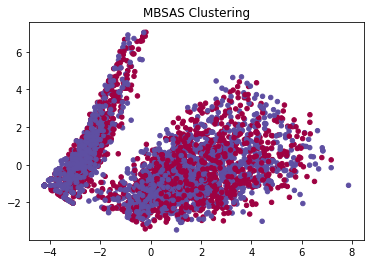

In [2]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette')
run_experiments(df, results)

# Trying without considering all the features

,thresholds,n_clusters,silhouette
0,3.0,3,0.157696
1,3.0,3,0.157696
2,3.0,3,0.157696
3,3.0,3,0.157696
4,3.0,3,0.157696


## 

### Running the experimentation

n of clusters: 3


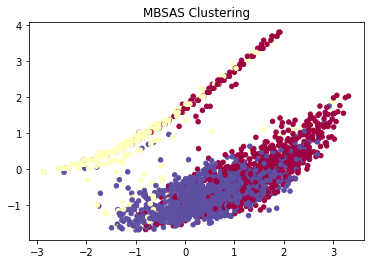

In [3]:
df = load_dataset(['CustomerID','Mean Days btw Purchases', 'Mean Products In Basket', 'Money Spent Entropy'])
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette')
run_experiments(df, results)


# Trying on a dataset reduced to 2D

,thresholds,n_clusters,silhouette
0,5.0,3,0.395496
1,5.0,3,0.395496
2,5.0,3,0.395496
3,5.0,3,0.395496
4,5.0,3,0.395496


## 

### Running the experimentation

n of clusters: 3


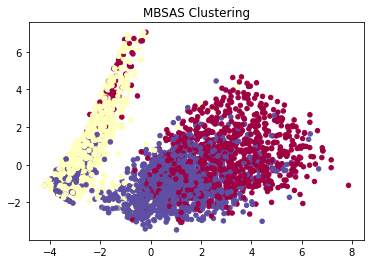

In [4]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=reduced_df, order_by='silhouette')
run_experiments(reduced_df, results)